# Importing packages and data

In this part of the code we import relevant libraries and load the desired dataset. The primary libraries are yfinance and torch. The torch library is a product of the bigger pytorch library, which is a maschine learning library. We use torch to make deep learning operations and tensor computations. We use “yfinance” to import the daily stock price of AAPL for the last 5 years (1248 days of data).


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
# Import data
end_date = pd.Timestamp.today()
start_date = end_date - pd.DateOffset(years=5)  # Last 5 years
df = yf.download('AAPL', start=start_date, end=end_date)
df = df[['Close']]
df = df.sort_index()

[*********************100%***********************]  1 of 1 completed


# 1. Feature Selection

We use the column “Close” as our target value we want to predict.
The data is sequential in nature which makes it pertinent to use recurrent neural network or Long-Short-Term-Memory. Furthermore we seek to solve a regression dilemma.

In [3]:
df.head()

Price,Close
Ticker,AAPL
Date,
2020-02-10,78.119232
2020-02-11,77.647903
2020-02-12,79.491882
2020-02-13,78.925827
2020-02-14,78.945251


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1257 entries, 2020-02-10 to 2025-02-07
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   (Close, AAPL)  1257 non-null   float64
dtypes: float64(1)
memory usage: 19.6 KB


# 2. Feature Engineering

To feed our model with information to enable it in predicting the close for a given day we feed the model with additional information. “lag_5” refers to the close 5 days ago, i.e. in the 5-day structure (given that we do not have weekends in the data) it is the previous week's close for that given day. Also we provide the model with “rolling_mean_10” and “rolling_sd_10” which is the mean and standard deviation for the last rolling 10 days, i.e. always taking into account the 10 previous days of data to provide context.

We use a limited amount of features as our concern is overfitting. While at the same time we would want to utilize as many features as possible, we also need to take into account the concept of overfitting which is prevalent in supervised machine learning, hence we use not as many features as one could have perhaps used.


In [5]:
# Lag features and Rolling Features
df['lag_5'] = df['Close'].shift(5)
df['rolling_mean_10'] = df['Close'].rolling(window=10).mean()
df['rolling_sd_10'] = df['Close'].rolling(window=10).std()
df.dropna(inplace=True)

# 3. Data Preprocessing

Min-max scaling is a normalization technique that rescales data to a fixed range, usually [0,1]. This ensures that all features are on the same scale, preventing those with larger numerical ranges from dominating the model. By preserving the relative relationships between values, min-max scaling helps improve the performance and stability of machine learning algorithms. However, outliers can fall outside the [0,1] range, as they extend beyond the original minimum and maximum values.

In [6]:
# Normalize the Data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df)

# 4. Train-Test (or Train-Validation-Test) Split

As mentioned previously we are concerned with overfitting since we are working with supervised machine learning. The nature of machine learning necessitates the presence of a quality check on a potentially overfitted model. To ensure this we split the data 80-20, 80% being the training dataset and 20% being the test dataset. A key difference between these is that the test dataset remains completely untouched aand is only used to evaluate the precision of the trained model.
Furthermore our project also employs validation data. This is done in further attempts to lessen the possibility of overfitting the model. This plays a role when we undergo the process of hyperparameter tuning. The test dataset is used later in the document when we evaluate the trained and hypertuned model.


In [7]:
#Split Data into Training and Testing Sets
train_size = int(len(data_scaled) * 0.8)
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

# Further split the training data into training and validation sets
train_valid_size = int(len(train_data) * 0.8)
train_data_final = train_data[:train_valid_size]
valid_data = train_data[train_valid_size:]

#5. Define Your Neural Network Architecture in PyTorch


The hyperparameter of timesteps refers to the amount of historical data the RNN considers in its prediction. Here considerations are that if we use a too large timestep value we have a risk of vanishing gradients, i.e. RNN does not take into account older values anyways hence wasted computations. This means that our scope for this prediction is more short-term than long-term, if we wanted to actually use more historical data we would have to consider swapping to LSTM instead.

In this step we also perform the data conversion from Pandas Dataframe → Numpy Array → Pytorch Tensor → Pytorch Dataset → Pytorch Dataloader. These steps are mostly in place due to considerations of performance, allowing GPU usage, and also using Dataloader as this enables sequential sampling without shuffling, i.e. randomizing, which we do not want due to the nature of sequential data where the surrounding data matters for the context.


In [8]:
# Prepare Data for RNN Input
def create_sequences_multivariate(data, n_timesteps, target_column_index):
    X = []
    y = []
    for i in range(len(data) - n_timesteps):
        seq_x = data[i:i + n_timesteps]
        seq_y = data[i + n_timesteps, target_column_index]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_timesteps = 1
n_features = data_scaled.shape[1]
target_column_index = 0  # 'Close' is the target column

# Create sequences for training, validation, and testing
X_train, y_train = create_sequences_multivariate(train_data_final, n_timesteps, target_column_index)
X_valid, y_valid = create_sequences_multivariate(valid_data, n_timesteps, target_column_index)
X_test, y_test = create_sequences_multivariate(test_data, n_timesteps, target_column_index)

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_valid = torch.tensor(X_valid, dtype=torch.float32)
y_valid = torch.tensor(y_valid, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [9]:
# Create DataLoaders
train_dataset = TensorDataset(X_train, y_train)
valid_dataset = TensorDataset(X_valid, y_valid)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

A RNN  is a type of neural network designed for sequential data by maintaining a hidden state that captures information from previous steps.
Imagine reading a sentence word by word. Each word helps you understand the next one better because you remember what came before. An RNN works the same way. it processes one input at a time while carrying over information from previous inputs.

At each step, the RNN receives:

- The current input (e.g., a word in a sentence or a point in a time series).
- A hidden state, which stores memory from previous steps.

It combines both pieces of information, updates the memory, and produces an output. This process repeats for every step in the sequence. The hidden state acts like a rolling summary of what the model has seen so far.
A mathematical approach to RNN processes sequential data step by step, maintaining a memory of past inputs. At each time step \( t \), the RNN receives an input \( x_t \) and a **hidden state** \( h_{t-1} \) (memory from the previous step). It combines these to produce the current **hidden state** \( h_t \) using the formula:


Now, let's dive into the mathematical approach behind a RNNs hidden state. The RNN updates its hidden state and produces an output using the following formulas:

The current hidden state is calculated as:

\
 \begin{array}{c}
    W_h \cdot h_{t-1}
    + W_x \cdot x_t
    + b
  \end{array}

where:
- \( W_h \) and \( W_x \) are the weight matrices,
- \( b \) is a bias term,
- \( f \) is an activation function (often **tanh** or **ReLU**).

The **output** \( y_t \) at each step is given by:

\
 \begin{array}{c}
    y_t = \ W_y \cdot h_t \ + b_y
  \end{array}
This formulation allows the RNN to retain information from past inputs and use it to influence future predictions.



In [10]:
# Build the RNN Model
# 1. Creating a FeedForwardNetwork
# 1.1 Structure (Architecture) of NN
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size=50, output_size=1):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, h_n = self.rnn(x)
        out = out[:, -1, :]  # Take the output at the last time step
        out = self.fc(out)
        return out

model = RNNModel(input_size=n_features, hidden_size=50, output_size=1)

# Define loss function and optimizer
# 1.2 Loss Function
criterion = nn.MSELoss()

# 1.3 Optmization Approch
optimizer = optim.Adam(model.parameters())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 50
train_losses = []
valid_losses = []

# 6. Training *Loop*

During this step we aim to have our model learn from the train dataset in order to make predictions. This involves feeding the model data and checking how the model performs and adjusting it in order to improve accuracy. In we use the following functions:
Forward pass: The forward pass is the process in which the model takes an input and generates an output using its current parameters. Mathematically, this involves applying the model’s learned weights to transform input data into predictions. In the case of a recurrent neural network (RNN), this process is repeated across multiple time steps, enabling the model to consider sequential dependencies.
Loss calculation: Loss calculation quantifies how far off the model’s predictions are from the actual values. The loss function serves as a performance measure and guides the optimization process. For our regression tasks, we chose to use Mean Squared Error (MSE).
Backwards pass: The backward pass involves computing the gradients of the loss function with respect to the model’s weights. This step determines how much each weight contributed to the error, guiding the necessary adjustments.
Updating weights: Once the gradients are computed, the model’s weights are updated to minimize the loss. This is done using an optimizer, such as Stochastic Gradient Descent (SGD) or Adam.
This process is repeated over multiple epochs, leading to better generalization on unseen data.


In [11]:
# Train the Model
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        # 2. Forward Pass
        outputs = model(inputs)
        # 3. FeedForward Evaluation
        loss = criterion(outputs.squeeze(), targets)
        # 4. Backward Pass / Gradient Calculation
        loss.backward()
        # 5. Back Propagation / Update Weights
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Evaluate on validation set
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for inputs, targets in valid_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            valid_loss += loss.item() * inputs.size(0)
    valid_loss /= len(valid_loader.dataset)
    valid_losses.append(valid_loss)

    if (epoch + 1) % 2 == 0:
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.6f}, Valid Loss: {valid_loss:.6f}')

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 2/50, Train Loss: 0.001339, Valid Loss: 0.004523
Epoch 4/50, Train Loss: 0.001397, Valid Loss: 0.004845
Epoch 6/50, Train Loss: 0.001326, Valid Loss: 0.005077
Epoch 8/50, Train Loss: 0.001313, Valid Loss: 0.005162
Epoch 10/50, Train Loss: 0.001266, Valid Loss: 0.004877
Epoch 12/50, Train Loss: 0.001365, Valid Loss: 0.005403
Epoch 14/50, Train Loss: 0.001330, Valid Loss: 0.005029
Epoch 16/50, Train Loss: 0.001195, Valid Loss: 0.004487
Epoch 18/50, Train Loss: 0.001140, Valid Loss: 0.004571
Epoch 20/50, Train Loss: 0.001006, Valid Loss: 0.003797
Epoch 22/50, Train Loss: 0.000889, Valid Loss: 0.003762
Epoch 24/50, Train Loss: 0.000779, Valid Loss: 0.003549
Epoch 26/50, Train Loss: 0.000641, Valid Loss: 0.003228
Epoch 28/50, Train Loss: 0.000491, Valid Loss: 0.002690
Epoch 30/50, Train Loss: 0.000409, Valid Loss: 0.002182
Epoch 32/50, Train Loss: 0.000358, Valid Loss: 0.001861
Epoch 34/50, Train Loss: 0.000329, Valid Loss: 0.001794
Epoch 36/50, Train Loss: 0.000302, Valid Loss: 0.001

# 7. Model Evaluation

In [12]:
model.eval()
with torch.no_grad():
    test_preds = model(X_test.to(device)).cpu().numpy()
    test_actuals = y_test.numpy()

print("Predictions:", test_preds)
print("Actual Values:", test_actuals)


Predictions: [[0.5973122 ]
 [0.59102273]
 [0.5847416 ]
 [0.58232605]
 [0.5826259 ]
 [0.5786954 ]
 [0.5782743 ]
 [0.58144075]
 [0.58683723]
 [0.5816542 ]
 [0.57802325]
 [0.581514  ]
 [0.57753164]
 [0.5744582 ]
 [0.5727191 ]
 [0.56262726]
 [0.55001354]
 [0.5491564 ]
 [0.54941964]
 [0.554862  ]
 [0.56288046]
 [0.56600296]
 [0.5593038 ]
 [0.5632539 ]
 [0.5591834 ]
 [0.5608055 ]
 [0.5680097 ]
 [0.5775392 ]
 [0.5552155 ]
 [0.55789846]
 [0.5532807 ]
 [0.54887   ]
 [0.5577425 ]
 [0.55676514]
 [0.5521882 ]
 [0.5497419 ]
 [0.5523279 ]
 [0.54564583]
 [0.5489242 ]
 [0.54631037]
 [0.5505431 ]
 [0.5446693 ]
 [0.5670319 ]
 [0.572284  ]
 [0.5620212 ]
 [0.55158645]
 [0.54871404]
 [0.54183185]
 [0.5353145 ]
 [0.5403162 ]
 [0.5454976 ]
 [0.5526074 ]
 [0.5549233 ]
 [0.5524658 ]
 [0.5645655 ]
 [0.5547992 ]
 [0.5505657 ]
 [0.561534  ]
 [0.5946613 ]
 [0.58885974]
 [0.59341973]
 [0.5955562 ]
 [0.5989856 ]
 [0.5891575 ]
 [0.59939134]
 [0.60148245]
 [0.60551286]
 [0.6026591 ]
 [0.6040022 ]
 [0.6052557 ]
 [0.608

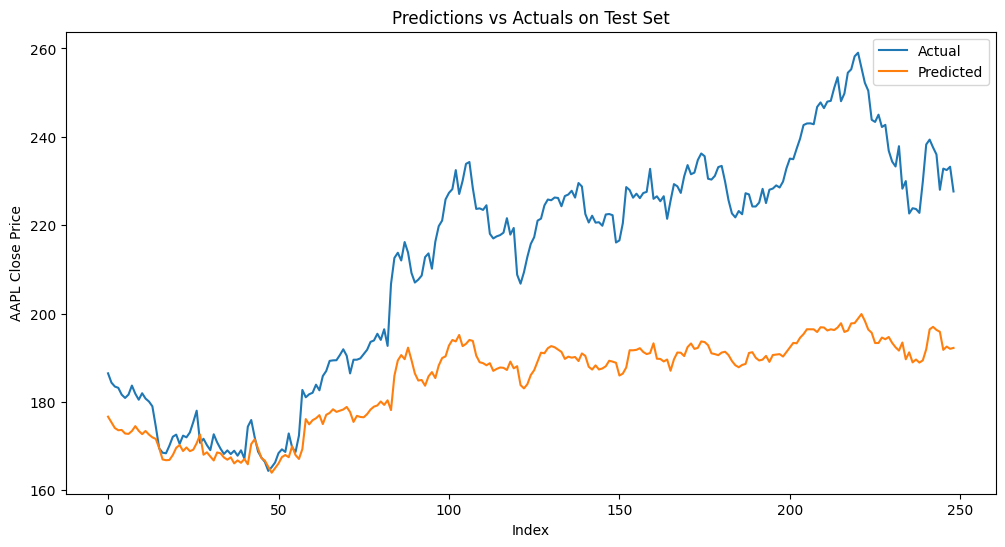

In [13]:
# Denormalize and Visualize Predictions
# Since we have multiple features, we need to only inverse transform the target variable
def denormalize(scaled_data, scaler, index):
     data = np.zeros((len(scaled_data), scaler.n_features_in_))
     data[:, index] = scaled_data[:, 0]
     data = scaler.inverse_transform(data)
     return data[:, index]

# Denormalize the predictions and actuals
test_preds_denorm = denormalize(test_preds, scaler, target_column_index)
test_actuals_denorm = denormalize(test_actuals.reshape(-1, 1), scaler, target_column_index)

# Plot predictions vs actuals for the test set
plt.figure(figsize=(12, 6))
plt.plot(test_actuals_denorm, label='Actual')
plt.plot(test_preds_denorm, label='Predicted')
plt.title('Predictions vs Actuals on Test Set')
plt.xlabel('Index')
plt.ylabel('AAPL Close Price')
plt.legend()
plt.show()

#8. Hyperparameter Experiments

Here we conduct experiments for the timesteps hyperparameter. First we try to see if adding more timesteps, i.e. longer sequence lengths, can improve our model. We find that it does not improve with 3, 5 and 30 timesteps.

However this can be bacause of vanishing gradient, i.e. too long sequences for the RNN model to handle, so we also try an experiment with LSTM, however here we still find no improvement than simply looking at a single timestep at a time, i.e. a single day of stock price to predict the next value with the features of lag5, mean10 and SD10 as well.

##Timestep Experiments

###Experiment 1 - 3 timesteps

In [14]:
# Prepare Data for RNN Input
def create_sequences_multivariate(data, n_timesteps, target_column_index):
    X = []
    y = []
    for i in range(len(data) - n_timesteps):
        seq_x = data[i:i + n_timesteps]
        seq_y = data[i + n_timesteps, target_column_index]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_timesteps = 3
n_features = data_scaled.shape[1]
target_column_index = 0  # 'Close' is the target column

# Create sequences for training, validation, and testing
X_train, y_train = create_sequences_multivariate(train_data_final, n_timesteps, target_column_index)
X_valid, y_valid = create_sequences_multivariate(valid_data, n_timesteps, target_column_index)
X_test, y_test = create_sequences_multivariate(test_data, n_timesteps, target_column_index)

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_valid = torch.tensor(X_valid, dtype=torch.float32)
y_valid = torch.tensor(y_valid, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoaders
train_dataset = TensorDataset(X_train, y_train)
valid_dataset = TensorDataset(X_valid, y_valid)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


# Build the RNN Model
# 1. Creating a FeedForwardNetwork
# 1.1 Structure (Architecture) of NN
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size=50, output_size=1):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, h_n = self.rnn(x)
        out = out[:, -1, :]  # Take the output at the last time step
        out = self.fc(out)
        return out

model = RNNModel(input_size=n_features, hidden_size=50, output_size=1)

# Define loss function and optimizer
# 1.2 Loss Function
criterion = nn.MSELoss()

# 1.3 Optmization Approch
optimizer = optim.Adam(model.parameters())

In [15]:
# Train the Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 50
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        # 2. Forward Pass
        outputs = model(inputs)
        # 3. FeedForward Evaluation
        loss = criterion(outputs.squeeze(), targets)
        # 4. Backward Pass / Gradient Calculation
        loss.backward()
        # 5. Back Propagation / Update Weights
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Evaluate on validation set
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for inputs, targets in valid_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            valid_loss += loss.item() * inputs.size(0)
    valid_loss /= len(valid_loader.dataset)
    valid_losses.append(valid_loss)

    if (epoch + 1) % 2 == 0:
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.6f}, Valid Loss: {valid_loss:.6f}')

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 2/50, Train Loss: 0.001675, Valid Loss: 0.005281
Epoch 4/50, Train Loss: 0.001535, Valid Loss: 0.005469
Epoch 6/50, Train Loss: 0.001271, Valid Loss: 0.004554
Epoch 8/50, Train Loss: 0.001081, Valid Loss: 0.002960
Epoch 10/50, Train Loss: 0.001141, Valid Loss: 0.002346
Epoch 12/50, Train Loss: 0.000972, Valid Loss: 0.002327
Epoch 14/50, Train Loss: 0.000757, Valid Loss: 0.002384
Epoch 16/50, Train Loss: 0.000686, Valid Loss: 0.002656
Epoch 18/50, Train Loss: 0.000609, Valid Loss: 0.003041
Epoch 20/50, Train Loss: 0.000545, Valid Loss: 0.003456
Epoch 22/50, Train Loss: 0.000524, Valid Loss: 0.003460
Epoch 24/50, Train Loss: 0.000488, Valid Loss: 0.003713
Epoch 26/50, Train Loss: 0.000463, Valid Loss: 0.003327
Epoch 28/50, Train Loss: 0.000432, Valid Loss: 0.003890
Epoch 30/50, Train Loss: 0.000405, Valid Loss: 0.003702
Epoch 32/50, Train Loss: 0.000400, Valid Loss: 0.003560
Epoch 34/50, Train Loss: 0.000387, Valid Loss: 0.003786
Epoch 36/50, Train Loss: 0.000377, Valid Loss: 0.003

###Experiment 2 - 5 timesteps

In [16]:
# Prepare Data for RNN Input
def create_sequences_multivariate(data, n_timesteps, target_column_index):
    X = []
    y = []
    for i in range(len(data) - n_timesteps):
        seq_x = data[i:i + n_timesteps]
        seq_y = data[i + n_timesteps, target_column_index]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_timesteps = 5
n_features = data_scaled.shape[1]
target_column_index = 0  # 'Close' is the target column

# Create sequences for training, validation, and testing
X_train, y_train = create_sequences_multivariate(train_data_final, n_timesteps, target_column_index)
X_valid, y_valid = create_sequences_multivariate(valid_data, n_timesteps, target_column_index)
X_test, y_test = create_sequences_multivariate(test_data, n_timesteps, target_column_index)

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_valid = torch.tensor(X_valid, dtype=torch.float32)
y_valid = torch.tensor(y_valid, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoaders
train_dataset = TensorDataset(X_train, y_train)
valid_dataset = TensorDataset(X_valid, y_valid)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


# Build the RNN Model
# 1. Creating a FeedForwardNetwork
# 1.1 Structure (Architecture) of NN
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size=50, output_size=1):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, h_n = self.rnn(x)
        out = out[:, -1, :]  # Take the output at the last time step
        out = self.fc(out)
        return out

model = RNNModel(input_size=n_features, hidden_size=50, output_size=1)

# Define loss function and optimizer
# 1.2 Loss Function
criterion = nn.MSELoss()

# 1.3 Optmization Approch
optimizer = optim.Adam(model.parameters())

In [17]:
# Train the Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 50
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        # 2. Forward Pass
        outputs = model(inputs)
        # 3. FeedForward Evaluation
        loss = criterion(outputs.squeeze(), targets)
        # 4. Backward Pass / Gradient Calculation
        loss.backward()
        # 5. Back Propagation / Update Weights
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Evaluate on validation set
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for inputs, targets in valid_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            valid_loss += loss.item() * inputs.size(0)
    valid_loss /= len(valid_loader.dataset)
    valid_losses.append(valid_loss)

    if (epoch + 1) % 2 == 0:
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.6f}, Valid Loss: {valid_loss:.6f}')

Epoch 2/50, Train Loss: 0.001468, Valid Loss: 0.003794
Epoch 4/50, Train Loss: 0.001282, Valid Loss: 0.003690
Epoch 6/50, Train Loss: 0.001132, Valid Loss: 0.003659
Epoch 8/50, Train Loss: 0.000992, Valid Loss: 0.003563
Epoch 10/50, Train Loss: 0.000850, Valid Loss: 0.003092
Epoch 12/50, Train Loss: 0.000746, Valid Loss: 0.002638
Epoch 14/50, Train Loss: 0.000704, Valid Loss: 0.002457
Epoch 16/50, Train Loss: 0.000668, Valid Loss: 0.002094
Epoch 18/50, Train Loss: 0.000602, Valid Loss: 0.002113
Epoch 20/50, Train Loss: 0.000533, Valid Loss: 0.002297
Epoch 22/50, Train Loss: 0.000465, Valid Loss: 0.002902
Epoch 24/50, Train Loss: 0.000444, Valid Loss: 0.003119
Epoch 26/50, Train Loss: 0.000431, Valid Loss: 0.003424
Epoch 28/50, Train Loss: 0.000396, Valid Loss: 0.003399
Epoch 30/50, Train Loss: 0.000391, Valid Loss: 0.003918
Epoch 32/50, Train Loss: 0.000388, Valid Loss: 0.004285
Epoch 34/50, Train Loss: 0.000383, Valid Loss: 0.004769
Epoch 36/50, Train Loss: 0.000382, Valid Loss: 0.004

###Experiment 3 - 30 timesteps

In [18]:
# Prepare Data for RNN Input
def create_sequences_multivariate(data, n_timesteps, target_column_index):
    X = []
    y = []
    for i in range(len(data) - n_timesteps):
        seq_x = data[i:i + n_timesteps]
        seq_y = data[i + n_timesteps, target_column_index]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_timesteps = 30
n_features = data_scaled.shape[1]
target_column_index = 0  # 'Close' is the target column

# Create sequences for training, validation, and testing
X_train, y_train = create_sequences_multivariate(train_data_final, n_timesteps, target_column_index)
X_valid, y_valid = create_sequences_multivariate(valid_data, n_timesteps, target_column_index)
X_test, y_test = create_sequences_multivariate(test_data, n_timesteps, target_column_index)

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_valid = torch.tensor(X_valid, dtype=torch.float32)
y_valid = torch.tensor(y_valid, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoaders
train_dataset = TensorDataset(X_train, y_train)
valid_dataset = TensorDataset(X_valid, y_valid)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


# Build the RNN Model
# 1. Creating a FeedForwardNetwork
# 1.1 Structure (Architecture) of NN
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size=50, output_size=1):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, h_n = self.rnn(x)
        out = out[:, -1, :]  # Take the output at the last time step
        out = self.fc(out)
        return out

model = RNNModel(input_size=n_features, hidden_size=50, output_size=1)

# Define loss function and optimizer
# 1.2 Loss Function
criterion = nn.MSELoss()

# 1.3 Optmization Approch
optimizer = optim.Adam(model.parameters())

In [19]:
# Train the Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 50
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        # 2. Forward Pass
        outputs = model(inputs)
        # 3. FeedForward Evaluation
        loss = criterion(outputs.squeeze(), targets)
        # 4. Backward Pass / Gradient Calculation
        loss.backward()
        # 5. Back Propagation / Update Weights
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Evaluate on validation set
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for inputs, targets in valid_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            valid_loss += loss.item() * inputs.size(0)
    valid_loss /= len(valid_loader.dataset)
    valid_losses.append(valid_loss)

    if (epoch + 1) % 2 == 0:
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.6f}, Valid Loss: {valid_loss:.6f}')

Epoch 2/50, Train Loss: 0.001885, Valid Loss: 0.006027
Epoch 4/50, Train Loss: 0.001378, Valid Loss: 0.004955
Epoch 6/50, Train Loss: 0.001160, Valid Loss: 0.003448
Epoch 8/50, Train Loss: 0.000833, Valid Loss: 0.002520
Epoch 10/50, Train Loss: 0.000704, Valid Loss: 0.002218
Epoch 12/50, Train Loss: 0.000640, Valid Loss: 0.002244
Epoch 14/50, Train Loss: 0.000626, Valid Loss: 0.002301
Epoch 16/50, Train Loss: 0.000516, Valid Loss: 0.002505
Epoch 18/50, Train Loss: 0.000581, Valid Loss: 0.003164
Epoch 20/50, Train Loss: 0.000575, Valid Loss: 0.003315
Epoch 22/50, Train Loss: 0.000595, Valid Loss: 0.005013
Epoch 24/50, Train Loss: 0.000495, Valid Loss: 0.003798
Epoch 26/50, Train Loss: 0.000477, Valid Loss: 0.005149
Epoch 28/50, Train Loss: 0.000462, Valid Loss: 0.005045
Epoch 30/50, Train Loss: 0.000453, Valid Loss: 0.004619
Epoch 32/50, Train Loss: 0.000443, Valid Loss: 0.004590
Epoch 34/50, Train Loss: 0.000436, Valid Loss: 0.004980
Epoch 36/50, Train Loss: 0.000423, Valid Loss: 0.004

## LSTM Experiment

In [20]:
# Step 5: Prepare Data for RNN Input
def create_sequences_multivariate(data, n_timesteps, target_column_index):
    X = []
    y = []
    for i in range(len(data) - n_timesteps):
        seq_x = data[i:i + n_timesteps]
        seq_y = data[i + n_timesteps, target_column_index]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_timesteps = 30
n_features = data_scaled.shape[1]
target_column_index = 0  # 'Close' is the target column

# Create sequences for training, validation, and testing
X_train, y_train = create_sequences_multivariate(train_data_final, n_timesteps, target_column_index)
X_valid, y_valid = create_sequences_multivariate(valid_data, n_timesteps, target_column_index)
X_test, y_test = create_sequences_multivariate(test_data, n_timesteps, target_column_index)

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_valid = torch.tensor(X_valid, dtype=torch.float32)
y_valid = torch.tensor(y_valid, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoaders
train_dataset = TensorDataset(X_train, y_train)
valid_dataset = TensorDataset(X_valid, y_valid)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [21]:
# Step 6: Build the LSTM Model
# 1. Creating a FeedForwardNetwork
# 1.1 Structure (Architecture) of NN
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=50, num_layers=2, output_size=1, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = out[:, -1, :]  # Last time step
        out = self.fc(out)
        return out


# Instantiate the LSTM model
model = LSTMModel(input_size=n_features, hidden_size=50, num_layers=1, output_size=1, dropout=0.2)

# Define loss function and optimizer
# 1.2 Loss Function
criterion = nn.MSELoss()

# 1.3 Optmization Approch
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 7: Train the Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 50
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        # 2. Forward Pass
        outputs = model(inputs)
        # 3. FeedForward Evaluation
        loss = criterion(outputs.squeeze(), targets)
        # 4. Backward Pass / Gradient Calculation
        loss.backward()
        # 5. Back Propagation / Update Weights
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for inputs, targets in valid_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            valid_loss += loss.item() * inputs.size(0)
    valid_loss /= len(valid_loader.dataset)
    valid_losses.append(valid_loss)

    if (epoch + 1) % 2 == 0:
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.6f}, Valid Loss: {valid_loss:.6f}')

# Step 8: Evaluate the Model
model.eval()
with torch.no_grad(): # this way prevents PyTorch from storing unnecessary information for backpropagation, making inference faster and more memory-efficient.
    test_preds = model(X_test.to(device)).cpu().numpy()
    test_actuals = y_test.numpy()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 2/50, Train Loss: 0.001799, Valid Loss: 0.005739
Epoch 4/50, Train Loss: 0.001940, Valid Loss: 0.003860
Epoch 6/50, Train Loss: 0.001165, Valid Loss: 0.003134
Epoch 8/50, Train Loss: 0.000645, Valid Loss: 0.003541
Epoch 10/50, Train Loss: 0.000586, Valid Loss: 0.004216
Epoch 12/50, Train Loss: 0.000584, Valid Loss: 0.004348
Epoch 14/50, Train Loss: 0.000549, Valid Loss: 0.004212
Epoch 16/50, Train Loss: 0.000531, Valid Loss: 0.003864
Epoch 18/50, Train Loss: 0.000506, Valid Loss: 0.003613
Epoch 20/50, Train Loss: 0.000484, Valid Loss: 0.003591
Epoch 22/50, Train Loss: 0.000469, Valid Loss: 0.004223
Epoch 24/50, Train Loss: 0.000440, Valid Loss: 0.003696
Epoch 26/50, Train Loss: 0.003932, Valid Loss: 0.013839
Epoch 28/50, Train Loss: 0.003328, Valid Loss: 0.012680
Epoch 30/50, Train Loss: 0.000736, Valid Loss: 0.007159
Epoch 32/50, Train Loss: 0.000457, Valid Loss: 0.005819
Epoch 34/50, Train Loss: 0.000411, Valid Loss: 0.005316
Epoch 36/50, Train Loss: 0.000398, Valid Loss: 0.004

In [22]:
# Combine the parameters of the LSTM layer and linear layer
params = list(model.parameters())

# Print the number of parameters
print("Number of parameters:", sum(p.numel() for p in params))

# Print the shapes of the parameters
for name, param in model.named_parameters():
    print("Name: ", name)
    print("shape: ", param.shape)
    print("Weight: ", param.data)

Number of parameters: 11251
Name:  lstm.weight_ih_l0
shape:  torch.Size([200, 4])
Weight:  tensor([[ 2.5881e-01, -5.5214e-01, -4.5115e-01, -8.9709e-02],
        [-2.5067e-01, -7.1144e-01, -5.4104e-01, -6.3452e-01],
        [ 6.1096e-01, -2.5789e-01, -6.2349e-04,  1.9467e-01],
        [-4.2437e-01, -3.8109e-01, -4.4862e-01, -8.6939e-01],
        [ 3.6592e-01, -3.5729e-01, -2.1492e-01,  2.3791e-01],
        [ 4.2757e-01,  2.1794e-01,  1.6990e-01, -5.4154e-02],
        [-2.0594e-01, -3.4822e-01, -1.6606e-01,  5.7400e-02],
        [-7.3148e-01, -7.6222e-01, -8.3705e-01, -5.9805e-01],
        [ 2.9740e-01, -1.3692e-02,  2.5490e-01,  5.9067e-02],
        [-2.6604e-01, -6.0287e-01, -5.7945e-01, -7.4628e-01],
        [-6.6500e-01, -6.1512e-01, -6.6181e-01, -7.7499e-01],
        [ 5.3027e-01,  1.4526e-01,  2.5466e-01,  1.1620e-01],
        [ 3.4990e-01, -3.4492e-01, -1.4487e-01,  5.4984e-02],
        [-6.8109e-01, -9.2950e-01, -8.3857e-01, -7.4637e-01],
        [ 1.2878e-02, -7.5429e-01, -7.131

#9. Documentation & Discussion

Through our analysis based on the stochastic batch gradient approach we found that our model tends to be overfitted. We experimented with time steps and RNN vs. LSTM. Working with time steps we found that a lower amount of steps resulted in a lower degree of overfitting with our 34th Epoch with the data of: "Epoch 34/50, Train Loss: 0.000329, Valid Loss: 0.001794", which was the lowest the validation loss ever got, which happened at just a singular timestep. For 3, 5 and 30 this did not improve, even when utilizing LSTM instead of RNN to consider the possibility of vanishing gradients hindering performance increases with more timesteps, which our experiment concluded was not the case however.


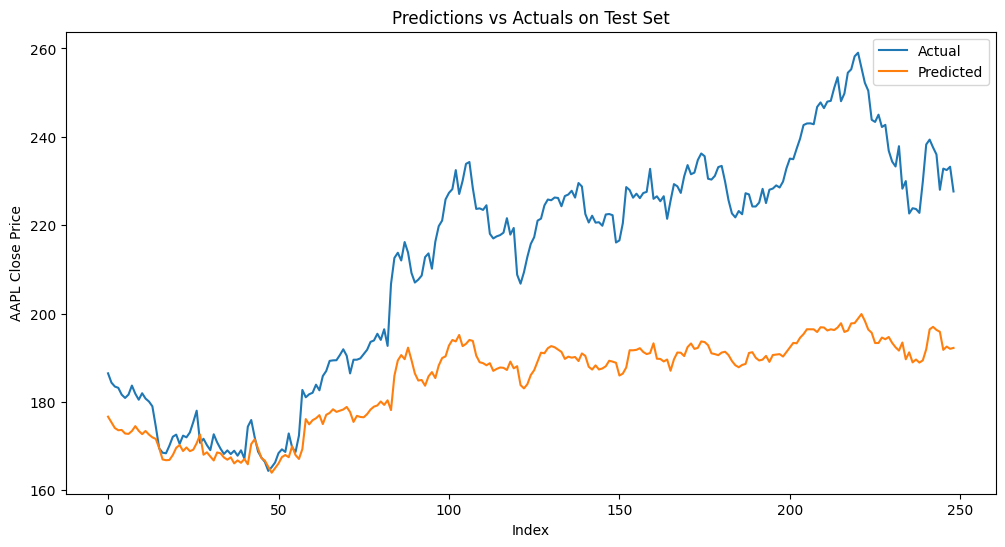